In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.explain import GNNExplainer
import matplotlib.pyplot as plt


In [40]:
# Load node features
df = pd.read_csv("data/node_features.csv")

# Binary classification label: Hotspot if >= 3 fatalities
df['Hotspot'] = (df['Fatalities'] >= 3).astype(int)

# Features
features = df.select_dtypes(include=np.number).drop(columns=['Latitude', 'Longitude', 'Fatalities', 'Hotspot'])
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(features), dtype=torch.float)
y = torch.tensor(df['Hotspot'].values, dtype=torch.long)


In [ ]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString
from scipy.spatial import cKDTree
from geopy.distance import geodesic

# Load road layer
road_gdf = gpd.read_file("data/singapore_road_network.gpkg", layer="edges")
G = nx.Graph()
for geom in road_gdf.geometry:
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        for start, end in zip(coords[:-1], coords[1:]):
            G.add_edge(start, end)

road_nodes = np.array([list(node) for node in G.nodes])
tree = cKDTree(road_nodes)

accident_coords = df[['Longitude', 'Latitude']].values
_, indices = tree.query(accident_coords)
snapped_nodes = road_nodes[indices]

unique_nodes, node_indices = np.unique(snapped_nodes, axis=0, return_inverse=True)
coord_to_index = {tuple(coord): i for i, coord in enumerate(unique_nodes)}

weighted_edges = []
edge_weights = []

for u, v in G.edges:
    if u in coord_to_index and v in coord_to_index:
        u_idx = coord_to_index[u]
        v_idx = coord_to_index[v]
        weighted_edges.append([u_idx, v_idx])
        weighted_edges.append([v_idx, u_idx])
        dist = geodesic(u[::-1], v[::-1]).meters
        edge_weights.extend([dist, dist])

edge_index = torch.tensor(weighted_edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_weights, dtype=torch.float)


In [42]:
# Masks
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
            y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)


In [43]:
class GATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.3)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x


In [44]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        truth = data.y[mask]
        acc = (pred == truth).float().mean().item()
    return acc, pred, truth


In [45]:
model = GATClassifier(in_channels=x.size(1), hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_accs, val_accs = [], []

for epoch in range(1, 201):
    loss = train(model, optimizer, data)
    if epoch % 10 == 0:
        val_acc, _, _ = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)
        print(f"Epoch {epoch}: Loss={loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 10: Loss=0.2502, Val Acc=0.9545
Epoch 20: Loss=0.1585, Val Acc=0.9545
Epoch 30: Loss=0.2168, Val Acc=0.9545
Epoch 40: Loss=0.1780, Val Acc=0.9545
Epoch 50: Loss=0.0803, Val Acc=0.9545
Epoch 60: Loss=0.1110, Val Acc=0.9545
Epoch 70: Loss=0.0508, Val Acc=0.9545
Epoch 80: Loss=0.1100, Val Acc=0.9545
Epoch 90: Loss=0.0631, Val Acc=0.9545
Epoch 100: Loss=0.0644, Val Acc=0.9545
Epoch 110: Loss=0.0756, Val Acc=0.9545
Epoch 120: Loss=0.0750, Val Acc=0.9545
Epoch 130: Loss=0.0401, Val Acc=0.9545
Epoch 140: Loss=0.0708, Val Acc=0.9545
Epoch 150: Loss=0.0362, Val Acc=0.9545
Epoch 160: Loss=0.0336, Val Acc=0.9545
Epoch 170: Loss=0.0393, Val Acc=0.9545
Epoch 180: Loss=0.0365, Val Acc=0.9545
Epoch 190: Loss=0.0483, Val Acc=0.9545
Epoch 200: Loss=0.0268, Val Acc=0.9545


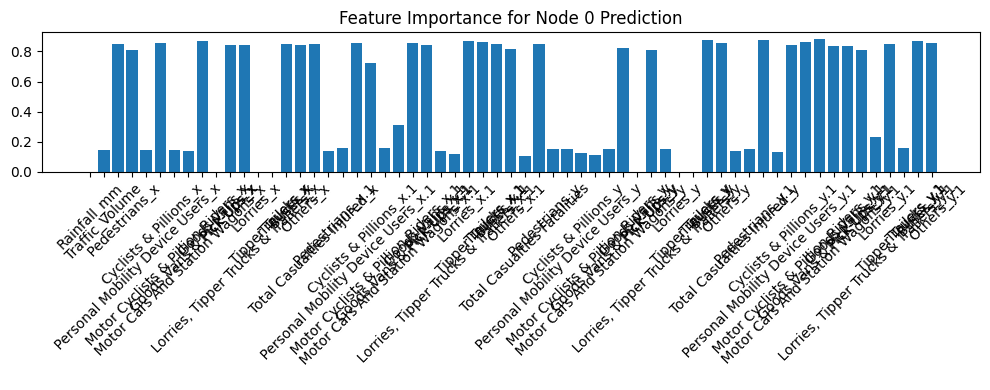

In [54]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

# Define model configuration using proper enums
model_config = ModelConfig(
    mode=ModelMode.multiclass_classification,
    task_level=ModelTaskLevel.node,
    return_type=ModelReturnType.log_probs  # or logits if no softmax in your model
)

# Build the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config
)

# Choose a test node
node_idx = data.test_mask.nonzero(as_tuple=True)[0][0].item()

# Generate explanation
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    index=node_idx
)

# Plot feature importance
feat_mask = explanation.node_mask.squeeze()
feat_mask = explanation.node_mask
feat_mask_for_node = feat_mask[node_idx]  # Get mask for specific node

# Convert to numpy
feat_values = feat_mask_for_node.detach().cpu().numpy()

# Plot it
plt.figure(figsize=(10, 4))
plt.bar(range(len(feat_values)), feat_values)
plt.xticks(range(len(features.columns)), features.columns, rotation=45)
plt.title(f"Feature Importance for Node {node_idx} Prediction")
plt.tight_layout()
plt.show()


In [49]:
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    index=node_idx
)

print(explanation.available_explanations)


['node_mask', 'edge_mask']


In [53]:
print("feat_mask shape:", feat_mask.shape)
print("feat_mask:", feat_mask)


feat_mask shape: torch.Size([108, 61])
feat_mask: tensor([[0.0000, 0.1521, 0.8450,  ..., 0.1586, 0.8594, 0.8503],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
